In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.metrics import mean_squared_error, mean_absolute_error
#rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

bookcolors = {'crimson': '#a50026', 'red': '#d73027', 'redorange': '#f46d43',
              'orange': '#fdae61', 'yellow': '#fee090', 'sky': '#e0f3f8', 
              'babyblue': '#abd9e9', 'lightblue': '#74add1', 'blue': '#4575b4',
              'purple': '#313695'}

def draw_vector(ax, x, y, dx, dy, yrange, c=bookcolors['red']):
    ax.plot([x,x+dx], [y,y+dy], c=c, linewidth=.8)
    ay = y+dy
    yrange *= 0.03
    ad = -yrange if dy>=0 else yrange
    ax.plot([x+dx-4,x+dx], [ay+ad,ay], c=c, linewidth=.8)
    ax.plot([x+dx,x+dx+4], [ay,ay+ad], c=c, linewidth=.8)
    
def data():
    df = pd.DataFrame(data={"sqfeet":[700,950,800,900,750]})
    df["rent"] = pd.Series([1125,1350,1135,1300,1150])
    df = df.sort_values('sqfeet')
    return df

def plot_composite(ax, gbm, stage, legend=True):
    line1, = ax.plot(df.sqfeet,df.rent, 'o')

    sqfeet_range = np.arange(700-10,950+10,.2)
    y_pred = []
    for x in sqfeet_range:
        delta = 0.0
        for t in gbm.stubs[0:stage]:
            delta += eta * t.l1predict(x)
        y_pred.append( f0 + delta )
    line2, = ax.plot(sqfeet_range, y_pred, linewidth=.8, linestyle='--', c='k')
    labs = ['\Delta_1', '\Delta_2', '\Delta_3']
    if stage==1:
        label = r"$f_0 + \eta \Delta_1$"
    else:
        label=r"$f_0 + \eta("+'+'.join(labs[:stage])+")$"

    if legend:
        ax.legend(handles=[line2], fontsize=16,
                  loc='center left', 
                  labelspacing=.1,
                  handletextpad=.2,
                  handlelength=.7,
                  frameon=True,
                  labels=[label])

In [2]:
class Stub:
    def __init__(self, X, residual, split):
        """
        We train on the residual or the sign vector but only to get
        the regions in the leaves with y_i. Then we grab mean/median
        of residual, y_i - F_{m-1}, in that region (L2/L1).
        """
        self.X, self.residual, self.split = X, residual, split
        self.left = self.residual[self.X<self.split]
        self.right = self.residual[self.X>=self.split]
        
    def l2predict(self,x):
        lmean = np.mean(self.left)
        rmean = np.mean(self.right)
        return lmean if x < self.split else rmean
        
    def l1predict(self,x):
        lmed = np.median(self.left)
        rmed = np.median(self.right)
        return lmed if x < self.split else rmed
    
class GBM:
    def __init__(self, f0, stubs, eta):
        self.f0, self.stubs, self.eta = f0, stubs, eta
        
    def l1predict(self, x):
        delta = 0.0
        for t in self.stubs:
            delta += eta * t.l1predict(x)
        return self.f0 + delta

In [3]:
df = data()
df

,sqfeet,rent
0,700,1125
4,750,1150
2,800,1135
3,900,1300
1,950,1350


## Train tree using sign vector

In [4]:
def boost(df, xcol, ycol, splits, eta, stages):
    """
    Update df to have direction_i, delta_i, F_i.
    Return MSE, MAE
    """
    f0 = df[ycol].median()
    df['F0'] = f0

    stubs = []
    for s in range(1,M+1):
        df[f'res{s}'] = df[ycol] - df[f'F{s-1}']
        df[f'sign{s}'] = np.sign(df[f'res{s}'])
        t = Stub(df.sqfeet, df[f'res{s}'], splits[s])
        stubs.append(t)
        df[f'delta{s}'] = [t.l1predict(x) for x in df[xcol]]
        df[f'F{s}'] = df[f'F{s-1}'] + eta * df[f'delta{s}']

    return GBM(f0, stubs, eta)

In [11]:
M = 3
eta = 1
splits = [None,850, 925, 725] # manually pick them
gbm = boost(df, 'sqfeet', 'rent', splits, eta, M)

mse = [mean_squared_error(df.rent, df['F'+str(s)]) for s in range(M+1)]
mae = [mean_absolute_error(df.rent, df['F'+str(s)]) for s in range(M+1)]
print(mse)
print(mae)
df

[12670.0, 315.0, 170.0, 165.0]
[78.0, 15.0, 10.0, 9.0]


,sqfeet,rent,F0,res1,sign1,delta1,F1,res2,sign2,delta2,F2,res3,sign3,delta3,F3
0,700,1125,1150.0,-25.0,-1.0,-15.0,1135.0,-10.0,-1.0,-5.0,1130.0,-5.0,-1.0,-5.0,1125.0
4,750,1150,1150.0,0.0,0.0,-15.0,1135.0,15.0,1.0,-5.0,1130.0,20.0,1.0,2.5,1132.5
2,800,1135,1150.0,-15.0,-1.0,-15.0,1135.0,0.0,0.0,-5.0,1130.0,5.0,1.0,2.5,1132.5
3,900,1300,1150.0,150.0,1.0,175.0,1325.0,-25.0,-1.0,-5.0,1320.0,-20.0,-1.0,2.5,1322.5
1,950,1350,1150.0,200.0,1.0,175.0,1325.0,25.0,1.0,25.0,1350.0,0.0,0.0,2.5,1352.5


In [12]:
o = ""
for i in range(len(df)):
    o += " & ".join([f"{v:.2f}" for v in df.iloc[i,:][['sqfeet','rent','F0','res1','sign1']]]) + "\\\\" + "\n"

#F = df[['sqfeet','rent',F0','F1','F2','F3']]
for i in range(len(df)):
    o += " & ".join([f"{v:.2f}" for v in df.iloc[i,5:]]) + r"\\" + "\n"

o = o.replace(".00", "")
print(o)

700 & 1125 & 1150 & -25 & -1\\
750 & 1150 & 1150 & 0 & 0\\
800 & 1135 & 1150 & -15 & -1\\
900 & 1300 & 1150 & 150 & 1\\
950 & 1350 & 1150 & 200 & 1\\
-15 & 1135 & -10 & -1 & -5 & 1130 & -5 & -1 & -5 & 1125\\
-15 & 1135 & 15 & 1 & -5 & 1130 & 20 & 1 & 2.50 & 1132.50\\
-15 & 1135 & 0 & 0 & -5 & 1130 & 5 & 1 & 2.50 & 1132.50\\
175 & 1325 & -25 & -1 & -5 & 1320 & -20 & -1 & 2.50 & 1322.50\\
175 & 1325 & 25 & 1 & 25 & 1350 & 0 & 0 & 2.50 & 1352.50\\



## Plot F0 vs rent and show vectors

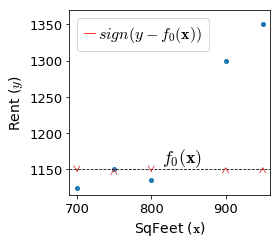

In [13]:
f0 = df.rent.median()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 3.5), sharey=True)


ax = axes
line1, = ax.plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4, label="$y$")
# fake a line to get smaller red dot
line2, = ax.plot([0,0],[0,0], c='r', markersize=4, label=r"$sign(y-f_0({\bf x}))$", linewidth=.8)
ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
ax.set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
ax.set_ylim(df.rent.min()-10, df.rent.max()+20)
ax.text(815, f0+10, r"$f_0({\bf x})$", fontsize=18)

ax.set_ylabel(r"Rent ($y$)", fontsize=14)
ax.set_xlabel(r"SqFeet (${\bf x}$)", fontsize=14)

# draw arrows
for x,y,yhat in zip(df.sqfeet,df.rent,df.F0):
    draw_vector(ax, x, yhat, 0, np.sign(y-yhat)*2, df.rent.max()-df.rent.min())
    
ax.legend(handles=[line2], fontsize=16,
          loc='upper left', 
          labelspacing=.1,
          handletextpad=.2,
          handlelength=.7,
          frameon=True)

plt.tight_layout()
plt.show()

## Show global weight not per leaf

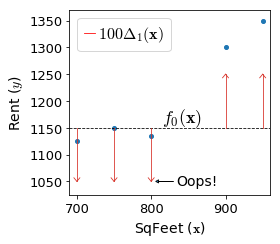

In [43]:
f0 = df.rent.median()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 3.5), sharey=True)


ax = axes
line1, = ax.plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4, label="$y$")
# fake a line to get smaller red dot
line2, = ax.plot([0,0],[0,0], c='r', markersize=4, label=r"$100 \Delta_1({\bf x})$", linewidth=.8)
ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
ax.set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
ax.set_ylim(df.rent.min()-100, df.rent.max()+20)
ax.text(815, f0+10, r"$f_0({\bf x})$", fontsize=18)

ax.arrow(830,1050, -20, 0, linewidth=.8, head_width=6, head_length=4)
ax.text(834, 1050-8, "Oops!", fontsize=14)

ax.set_ylabel(r"Rent ($y$)", fontsize=14)
ax.set_xlabel(r"SqFeet (${\bf x}$)", fontsize=14)

# draw arrows
for x,y,yhat in zip(df.sqfeet,df.rent,df.F0):
    draw_vector(ax, x, yhat, 0, (np.sign(y-yhat) if y-yhat>0 else -1)*100, df.rent.max()-df.rent.min())
    
ax.legend(handles=[line2], fontsize=16,
          loc='upper left', 
          labelspacing=.1,
          handletextpad=.2,
          handlelength=.7,
          frameon=True)

plt.tight_layout()
plt.show()

## Using leaf-specific Weights

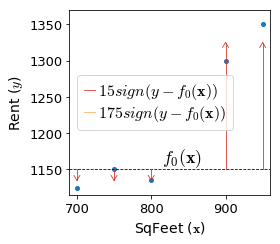

In [15]:
f0 = df.rent.median()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 3.5), sharey=True)

ax = axes
line1, = ax.plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4, label="$y$")
# fake a line to get smaller red dot
line2, = ax.plot([0,0],[0,0], c=bookcolors['red'], markersize=4, label=r"$15sign(y-f_0({\bf x}))$", linewidth=.8)
line3, = ax.plot([0,0],[0,0], c=bookcolors['orange'], markersize=4, label=r"$175sign(y-f_0({\bf x}))$", linewidth=.8)
ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
ax.set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
ax.set_ylim(df.rent.min()-10, df.rent.max()+20)
ax.text(815, f0+10, r"$f_0({\bf x})$", fontsize=18)

ax.set_ylabel(r"Rent ($y$)", fontsize=14)
ax.set_xlabel(r"SqFeet (${\bf x}$)", fontsize=14)

def draw_stage_residual(ax, df, stage):
    for x,d0,delta in zip(df.sqfeet,df[f'F{stage-1}'],df[f'F{stage}']):
        draw_vector(ax, x, d0, 0, delta-d0, df.rent.max()-df.rent.min())

draw_stage_residual(ax, df, 1)
# # draw arrows
# for x,y,yhat in zip(df.sqfeet,df.rent,df.F0):
#     if x<splits[1]:
#         draw_vector(ax, x, yhat, 0, np.sign(y-yhat)*15, df.rent.max()-df.rent.min())

# for x,y,yhat in zip(df.sqfeet,df.rent,df.F0):
#     if x>=splits[1]:
#         draw_vector(ax, x, yhat, 0, np.sign(y-yhat)*175, df.rent.max()-df.rent.min(),
#                    c=bookcolors['orange'])

ax.legend(handles=[line2,line3], fontsize=16,
          loc='center left', 
          labelspacing=.1,
          handletextpad=.2,
          handlelength=.7,
          frameon=True)

plt.tight_layout()
plt.savefig('/tmp/s.svg')
plt.show()

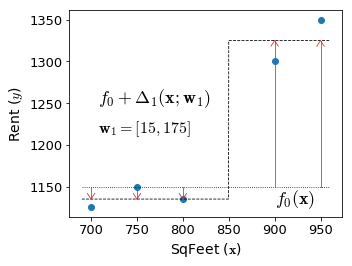

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3.8))

plot_composite(ax, gbm, 1, legend=False)

ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle=':', c='k')

for x,d0,delta in zip(df.sqfeet,df[f'F0'],df[f'F1']):
    draw_vector(ax, x, d0, 0, delta-d0, df.rent.max()-df.rent.min())

ax.text(708, 1250, r"$f_0 + \Delta_1({\bf x}; {\bf w}_1)$", fontsize=18)
ax.text(708, 1215, r"${\bf w}_1 = [15, 175]$", fontsize=16)
ax.text(900, f0-20, r"$f_0({\bf x})$", fontsize=18)

ax.set_ylabel(r"Rent ($y$)", fontsize=14)
ax.set_xlabel(r"SqFeet (${\bf x}$)", fontsize=14)

plt.tight_layout()

plt.show()

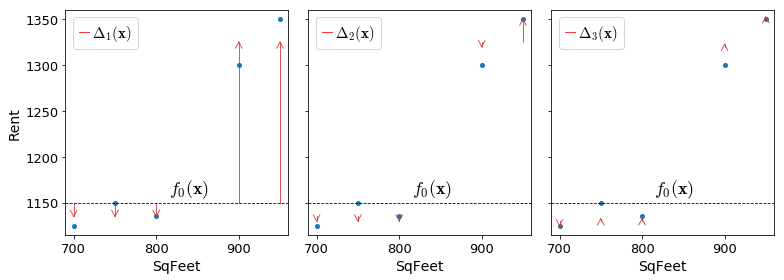

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharey=True)

def draw_stage_residual(ax, df, stage):
    for x,d0,delta in zip(df.sqfeet,df[f'F{stage-1}'],df[f'F{stage}']):
        draw_vector(ax, x, d0, 0, delta-d0, df.rent.max()-df.rent.min())

# PLOT 1

ax = axes[0]
f0 = df.rent.median()
line1, = ax.plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4, label="$y$")
draw_stage_residual(ax, df, stage=1)
# fake a line to get smaller red dot
line2, = ax.plot(700,1000,linewidth=.8, c='r', markersize=4)
ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
ax.text(815, f0+10, r"$f_0({\bf x})$", fontsize=18)
ax.set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
ax.set_ylim(df.rent.min()-10, df.rent.max()+10)
ax.set_xlabel(r"SqFeet", fontsize=14)
ax.set_ylabel(r"Rent", fontsize=14)
ax.legend(handles=[line2], fontsize=15,
          loc='upper left', 
          labelspacing=.1,
          handletextpad=.2,
          handlelength=.7,
          frameon=True,
          labels=["$\Delta_1({\\bf x})$"])

# PLOT 2

ax = axes[1]
line1, = ax.plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4, label="$y$")
draw_stage_residual(ax, df, stage=2)
# fake a line to get smaller red dot
line2, = ax.plot(700,1000,linewidth=.8, c='r', markersize=4)
ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
ax.text(815, f0+10, r"$f_0({\bf x})$", fontsize=18)
ax.set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
ax.set_ylim(df.rent.min()-10, df.rent.max()+10)
ax.set_xlabel(r"SqFeet", fontsize=14)
ax.legend(handles=[line2], fontsize=15,
          loc='upper left', 
          labelspacing=.1,
          handletextpad=.2,
          handlelength=.7,
          frameon=True,
          labels=["$\Delta_2({\\bf x})$"])

# PLOT 3

ax = axes[2]
line1, = ax.plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4, label="$y$")
draw_stage_residual(ax, df, stage=3)
# fake a line to get smaller red dot
line2, = ax.plot(700,1000,linewidth=.8, c='r', markersize=4)
ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
ax.text(815, f0+10, r"$f_0({\bf x})$", fontsize=18)
ax.set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
ax.set_ylim(df.rent.min()-10, df.rent.max()+10)
ax.set_xlabel(r"SqFeet", fontsize=14)
ax.legend(handles=[line2], fontsize=15,
          loc='upper left', 
          labelspacing=.1,
          handletextpad=.2,
          handlelength=.7,
          frameon=True,
          labels=["$\Delta_3({\\bf x})$"])

plt.tight_layout()
plt.savefig('/tmp/s.svg')
plt.show()

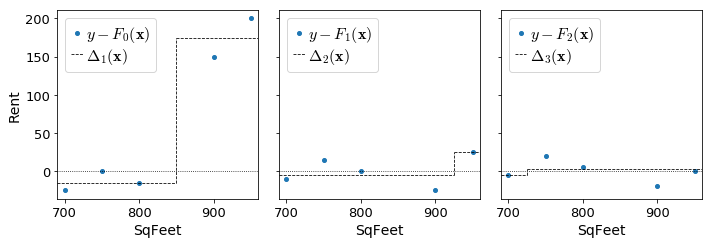

In [18]:
def draw_stub(ax, x_train, y_train, y_pred, split, stage):
    line1, = ax.plot(x_train, y_train, 'o',
                     markersize=4,
                     label="$y-F_"+str(stage-1)+"({\\bf x})$")
    label = r"$\Delta_"+str(stage)+r"({\bf x})$"
    left = y_pred[x_train<split]
    right = y_pred[x_train>split]
    lmean = np.mean(left)
    rmean = np.mean(right)
    line2, = ax.plot([x_train.min()-10,split], [lmean,lmean],
             linewidth=.8, linestyle='--', c='k', label=label)
    ax.plot([split,x_train.max()+10], [rmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    ax.plot([split,split], [lmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    ax.plot([x_train.min()-10,x_train.max()+10], [0,0],
             linewidth=.8, linestyle=':', c='k')
    ax.legend(handles=[line1,line2], fontsize=16,
              loc='upper left', 
              labelspacing=.1,
              handletextpad=.2,
              handlelength=.7,
              frameon=True)

def draw_residual(ax, x_train, y_train, y_hat):
    for x,y,yhat in zip(x_train, y_train, y_hat):
        draw_vector(ax, x, yhat, 0, y-yhat, df.rent.max()-df.rent.min())

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), sharey=True)

axes[0].set_ylabel(r"Rent", fontsize=14)
for a in range(3):
    axes[a].set_xlabel(r"SqFeet", fontsize=14)
    axes[a].set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)

draw_stub(axes[0], df.sqfeet, df.res1, df.delta1, splits[1], stage=1)
#draw_residual(axes[0], df.sqfeet,df.dir1,df.delta1)

draw_stub(axes[1], df.sqfeet, df.res2, df.delta2, splits[2], stage=2)
#draw_residual(axes[1], df.sqfeet,df.res2,df.delta2)

draw_stub(axes[2], df.sqfeet, df.res3, df.delta3, splits[3], stage=3)
#draw_residual(axes[2], df.sqfeet,df.dir3,df.delta3)

plt.tight_layout()
        
plt.savefig('/tmp/t.svg')
plt.show()

## Show model stages

In [19]:
df = data()
gbm = boost(df, 'sqfeet', 'rent', splits, eta, M)
df['deltas12'] = 0.7 * df[['delta1','delta2']].sum(axis=1)
df['deltas123'] = 0.7 * df[['delta1','delta2','delta3']].sum(axis=1)
df['deltas'] = 0.7 * df[['delta1','delta2','delta3']].sum(axis=1) # sum deltas

df[['sqfeet','rent','F0','delta1','delta2','delta3','deltas','deltas12','deltas123']]

,sqfeet,rent,F0,delta1,delta2,delta3,deltas,deltas12,deltas123
0,700,1125,1150.0,-15.0,-5.0,-5.0,-17.50,-14.0,-17.50
4,750,1150,1150.0,-15.0,-5.0,2.5,-12.25,-14.0,-12.25
2,800,1135,1150.0,-15.0,-5.0,2.5,-12.25,-14.0,-12.25
3,900,1300,1150.0,175.0,-5.0,2.5,120.75,119.0,120.75
1,950,1350,1150.0,175.0,25.0,2.5,141.75,140.0,141.75


TypeError: plot_composite() missing 1 required positional argument: 'stage'

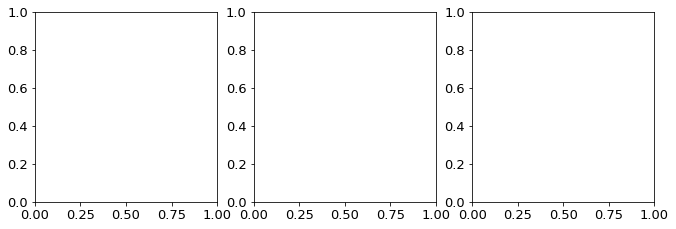

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11.1, 3.5))

plot_composite(axes[0], 1)
plot_composite(axes[1], 2)
plot_composite(axes[2], 3)

plt.tight_layout()
plt.savefig('/tmp/u.svg')
plt.show()